In [1]:
# pip list --format=freeze > requirements.txt
# pip install -r requirements.txt

In [2]:
%matplotlib inline

In [3]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import pipeline
from datetime import datetime

# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [4]:
path = "/Users/emilygong/Desktop/RUW-Oil-Prediction/data"
os.chdir(path)

# Read in the Dataset

In [9]:
final = pd.read_csv('oil_price.csv')
final['date'] = pd.to_datetime(final['date'])
final.columns = ['date', 'price']
final = final[final['date'] > datetime(2022, 2, 24)]

# Simple Plots for Oil Prices starting the RUW

array([<AxesSubplot:xlabel='date'>], dtype=object)

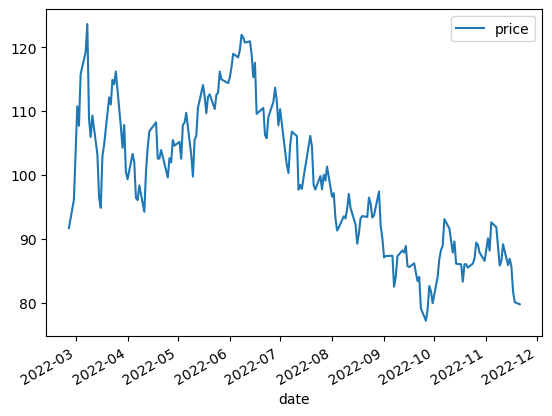

In [10]:
price = final.set_index('date')
price.plot(subplots=True)

# Stationary? Plot ACF & PACF and do adf_test to find out

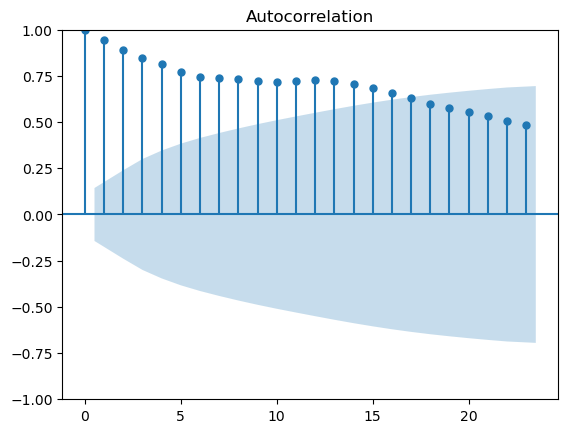

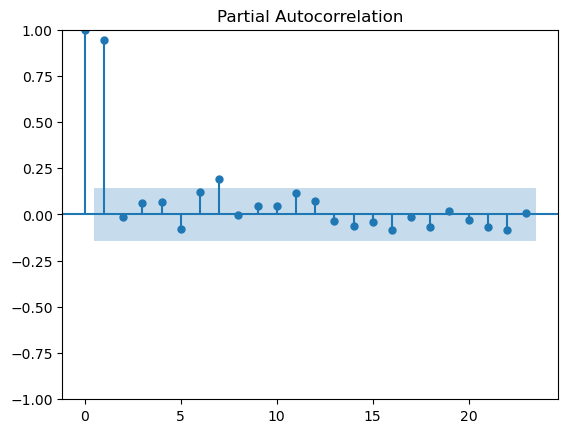

In [11]:
acf_original = plot_acf(price['price'])
pacf_original = plot_pacf(price['price'], method='ywm')

The ACF plot shows the correlations with the lags are high and positive with very slow decay. While the PACF plot shows the partial autocorrelations have a single spike at lag 1. These are both signs of a trended time series. So our time series is not stationary.

In [12]:
adf_test = adfuller(price['price'])
print(f'p-value: {adf_test[1]}')

p-value: 0.48142320275094447


This result shows a large p-value, which means the test fails to reject the null hypothesis. So the ADF test also suggests that our time series is non-stationary.

# Transform to stationary by differencing

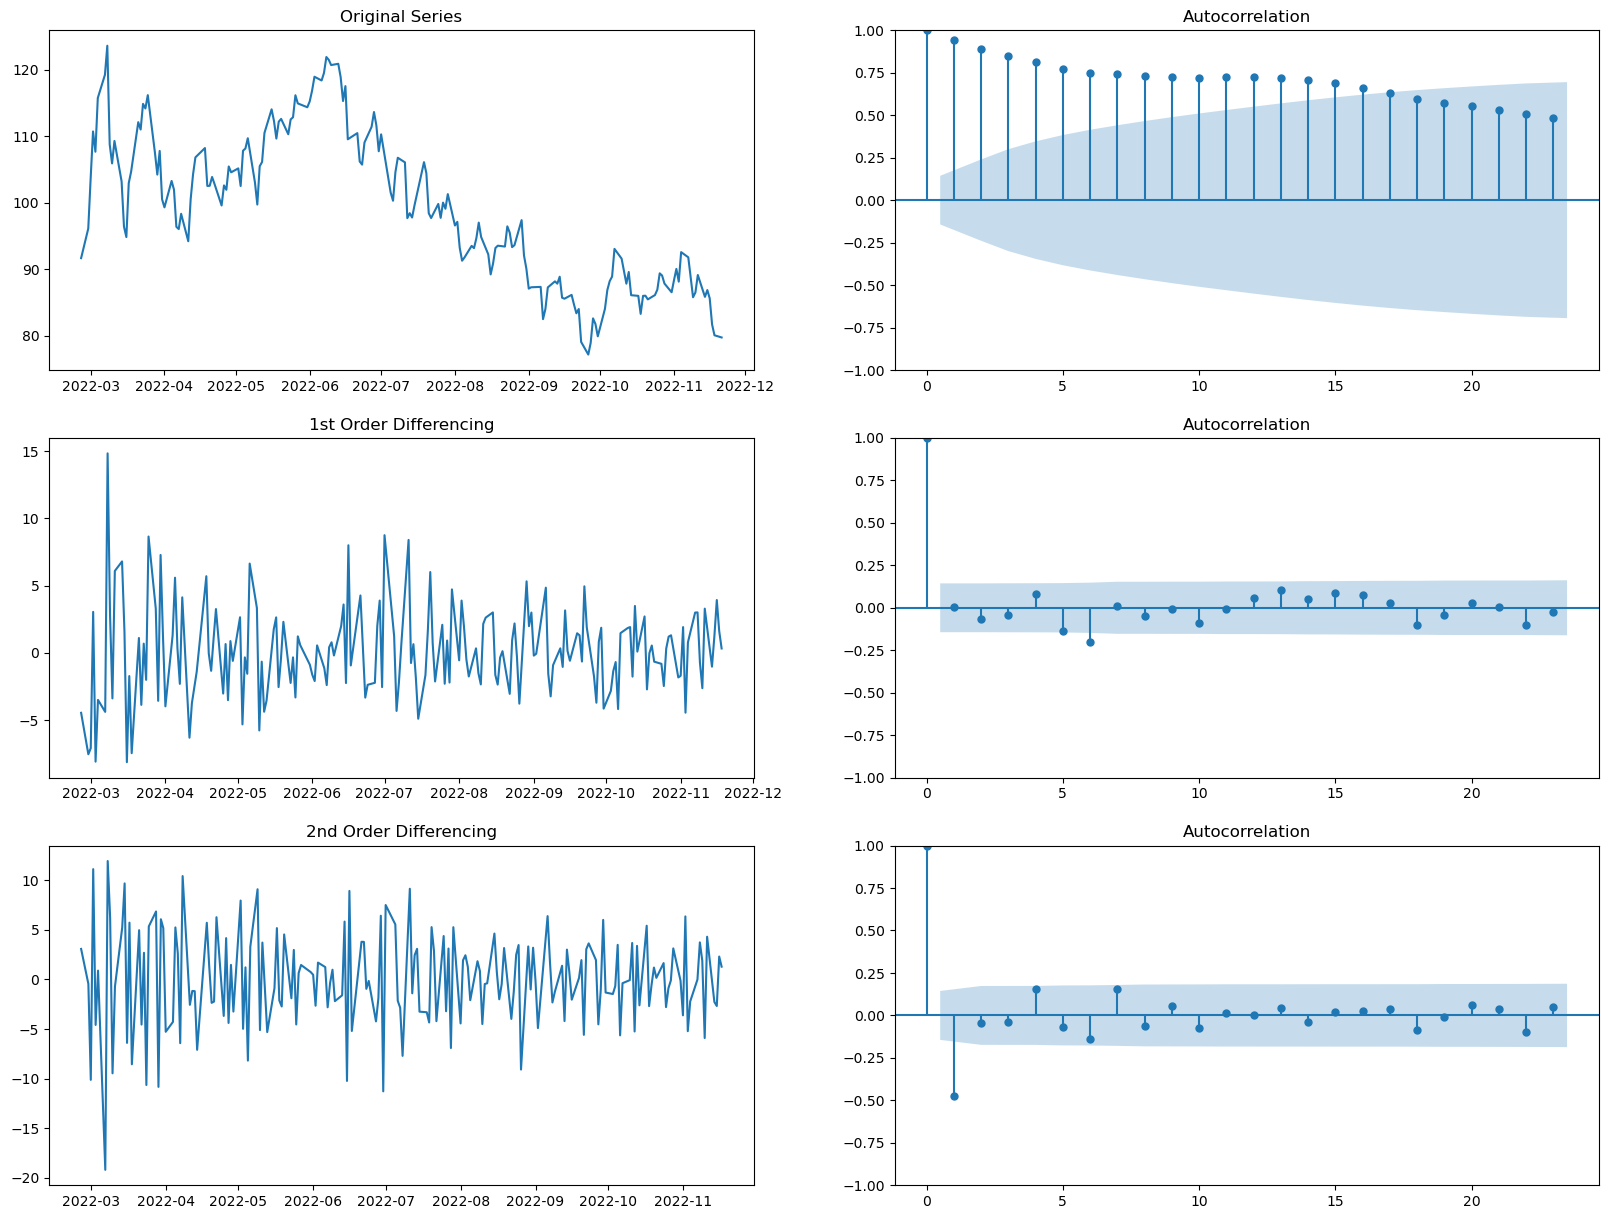

In [13]:
df = price[['price']]

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False, figsize=[20, 15])
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_acf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

# Interpolate for missing values

Oil prices are only available during the week, but for better results, we choose to interpolate 

In [17]:
na = np.arange(np.datetime64("2022-02-25"), np.datetime64("2022-11-22"))
df = pd.DataFrame({'date': na})
df.index = df['date']
df = df.join(price, how = 'left')
df = df[['price']]
price_full = df.interpolate()

# Fit auto ARIMA & Predict

In [19]:
price_full_diff = price_full.diff().dropna()
price_full_diff_2 = price_full.diff().diff().dropna()

In [20]:
model = pm.auto_arima(price_full, seasonal=False,
                      start_p=0, start_q=0, m=1, max_order=2, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)
model_diff = pm.auto_arima(price_full_diff, seasonal=False,
                      start_p=0, start_q=0, m=1, max_order=2, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)
model_diff_2 = pm.auto_arima(price_full_diff_2, seasonal=False,
                      start_p=0, start_q=0, m=1, max_order=2, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1275.745, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1277.158, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1277.155, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1273.825, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1279.131, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.234 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1273.825, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1275.230, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1275.228, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1277.205, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1275.745, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.127 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1442.761, Time=

# Interpret the Model

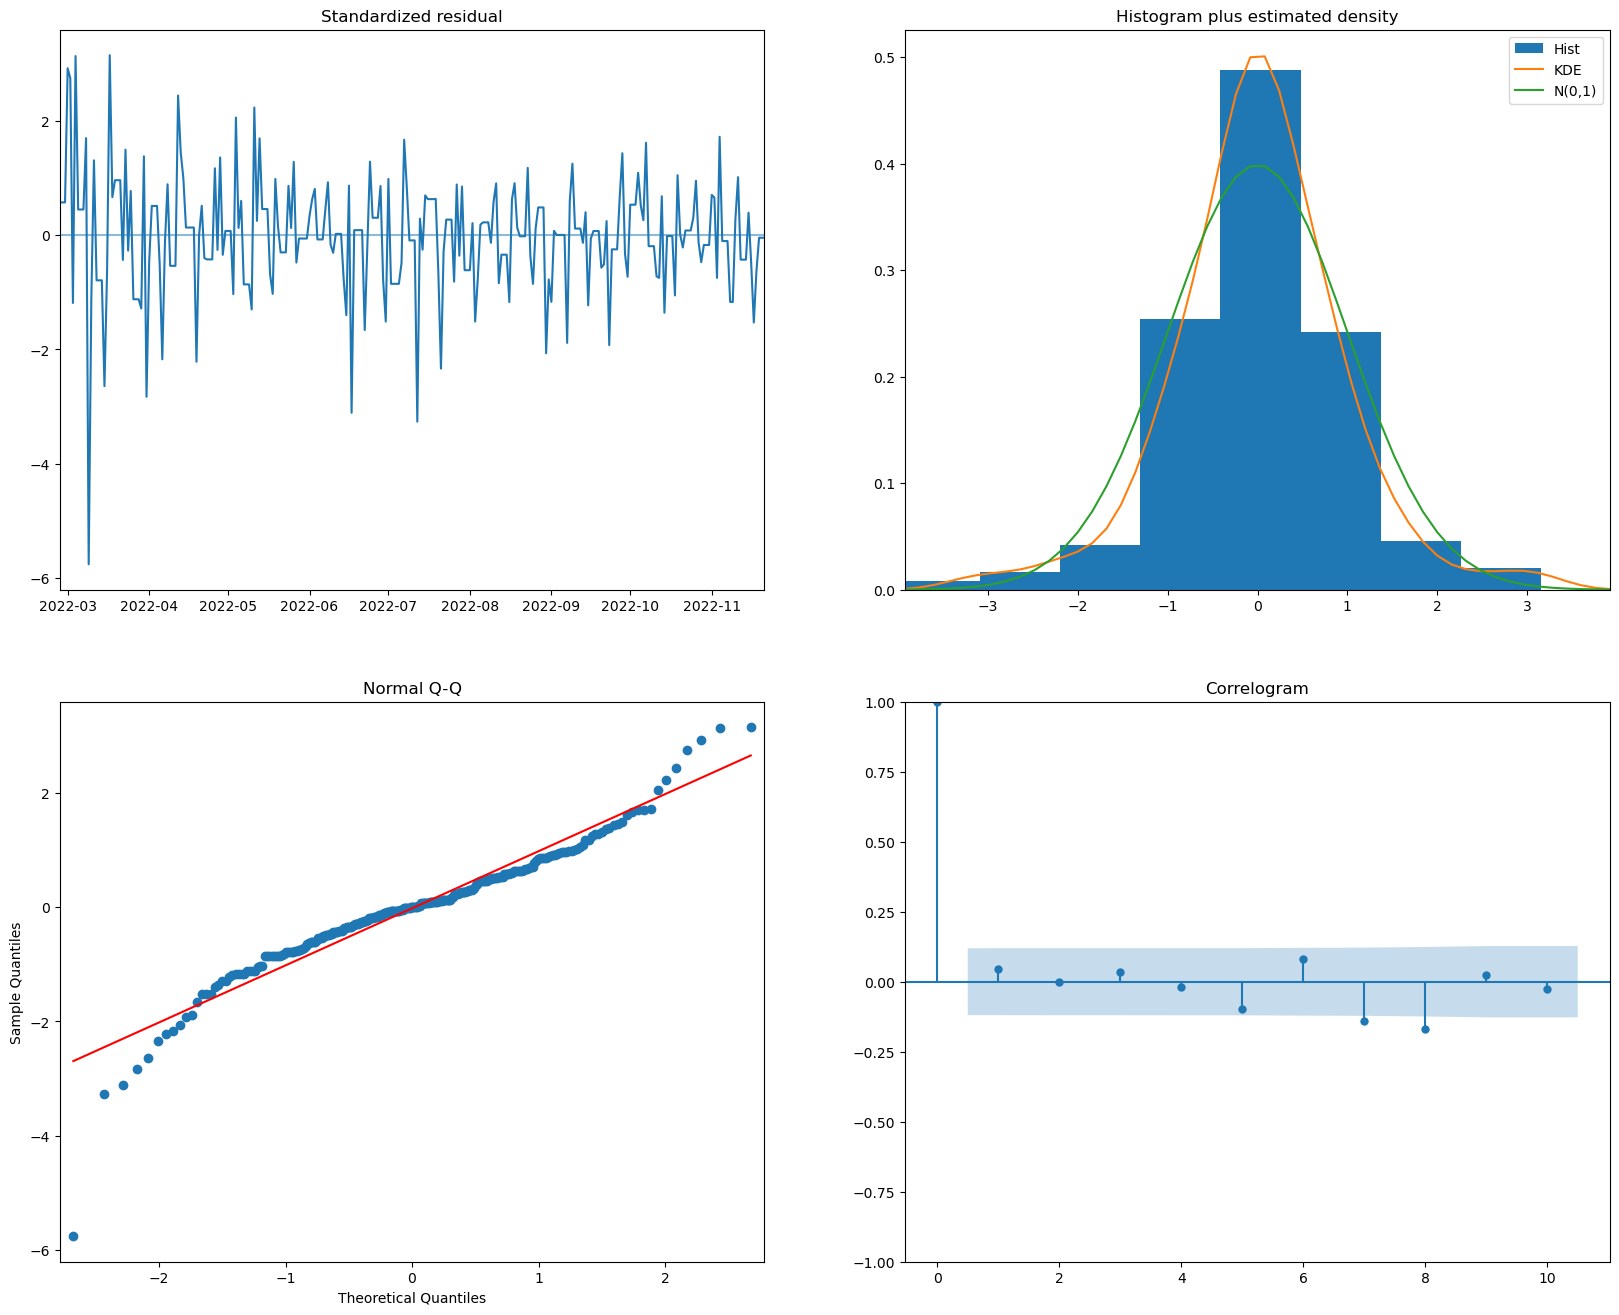

In [21]:
model.plot_diagnostics(figsize=(20,16))
plt.show()

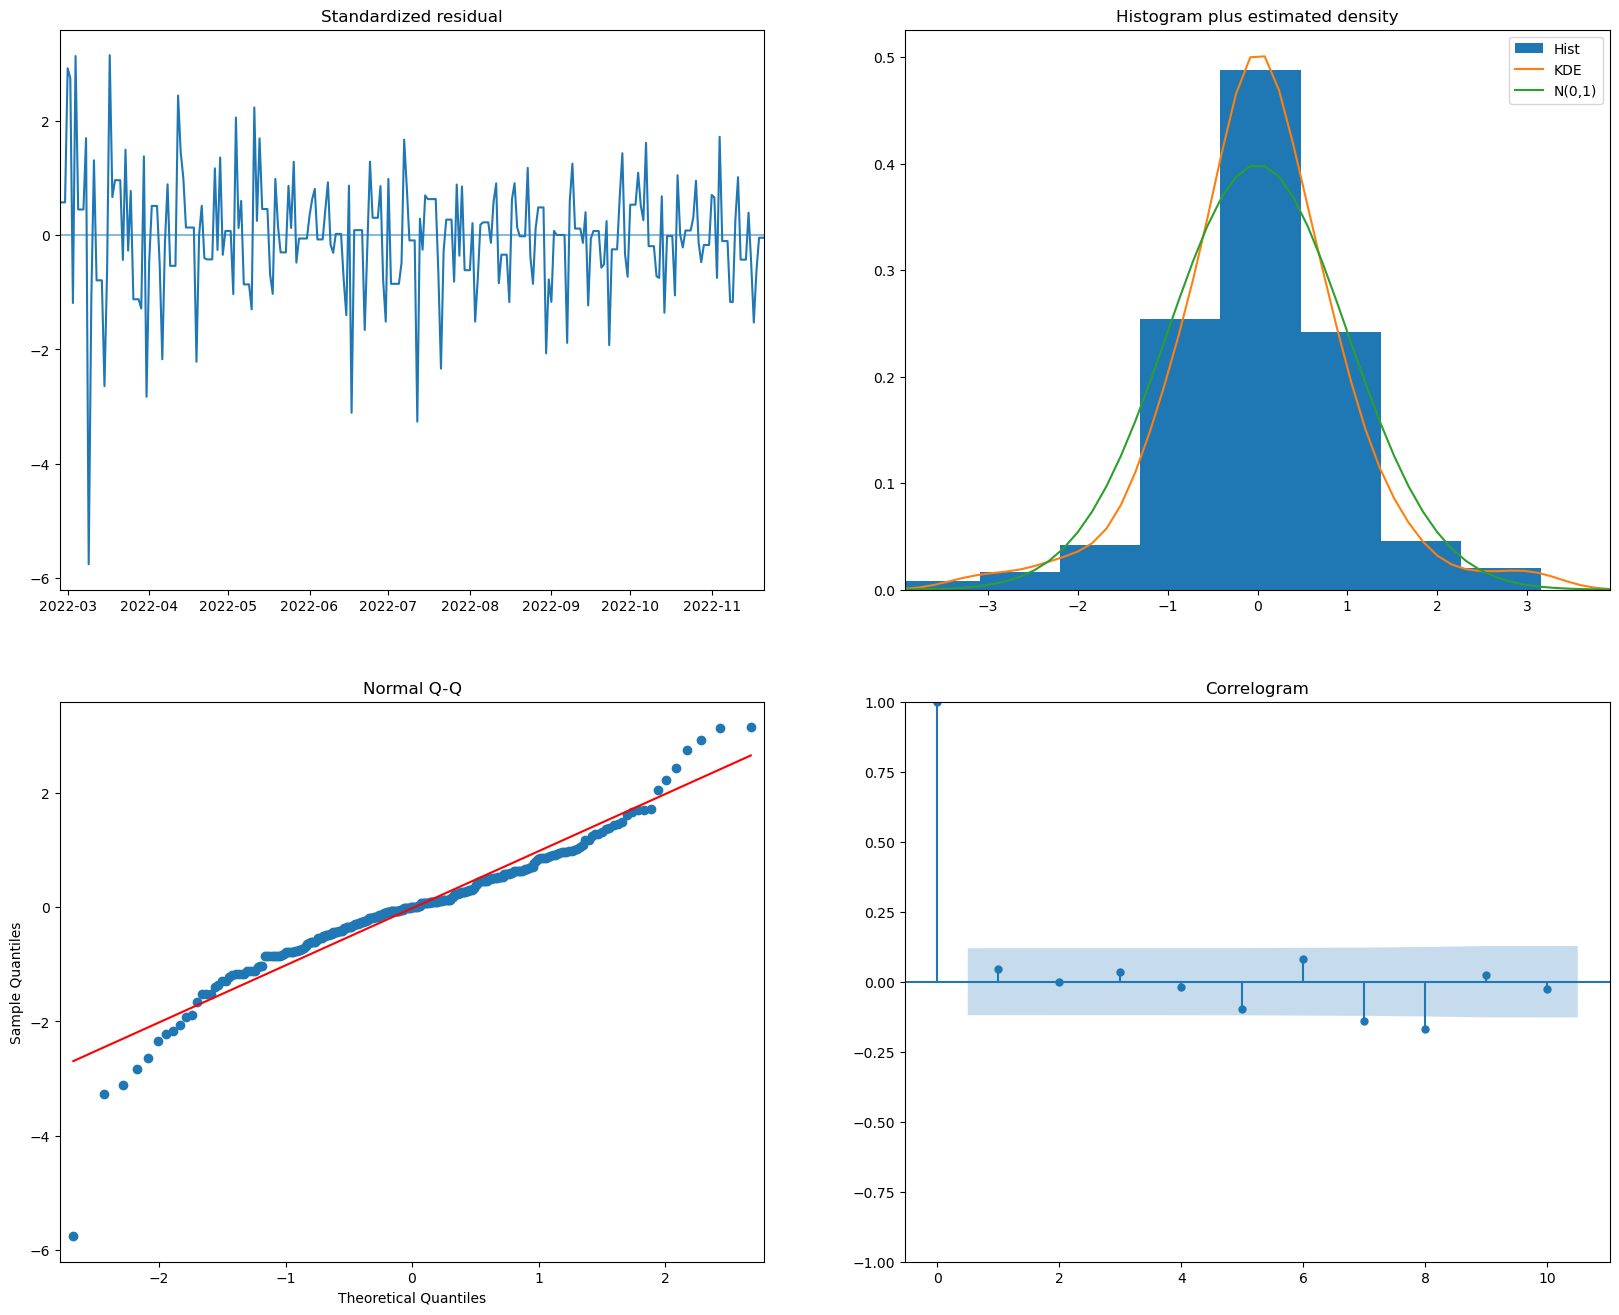

In [22]:
model_diff.plot_diagnostics(figsize=(20,16))
plt.show()

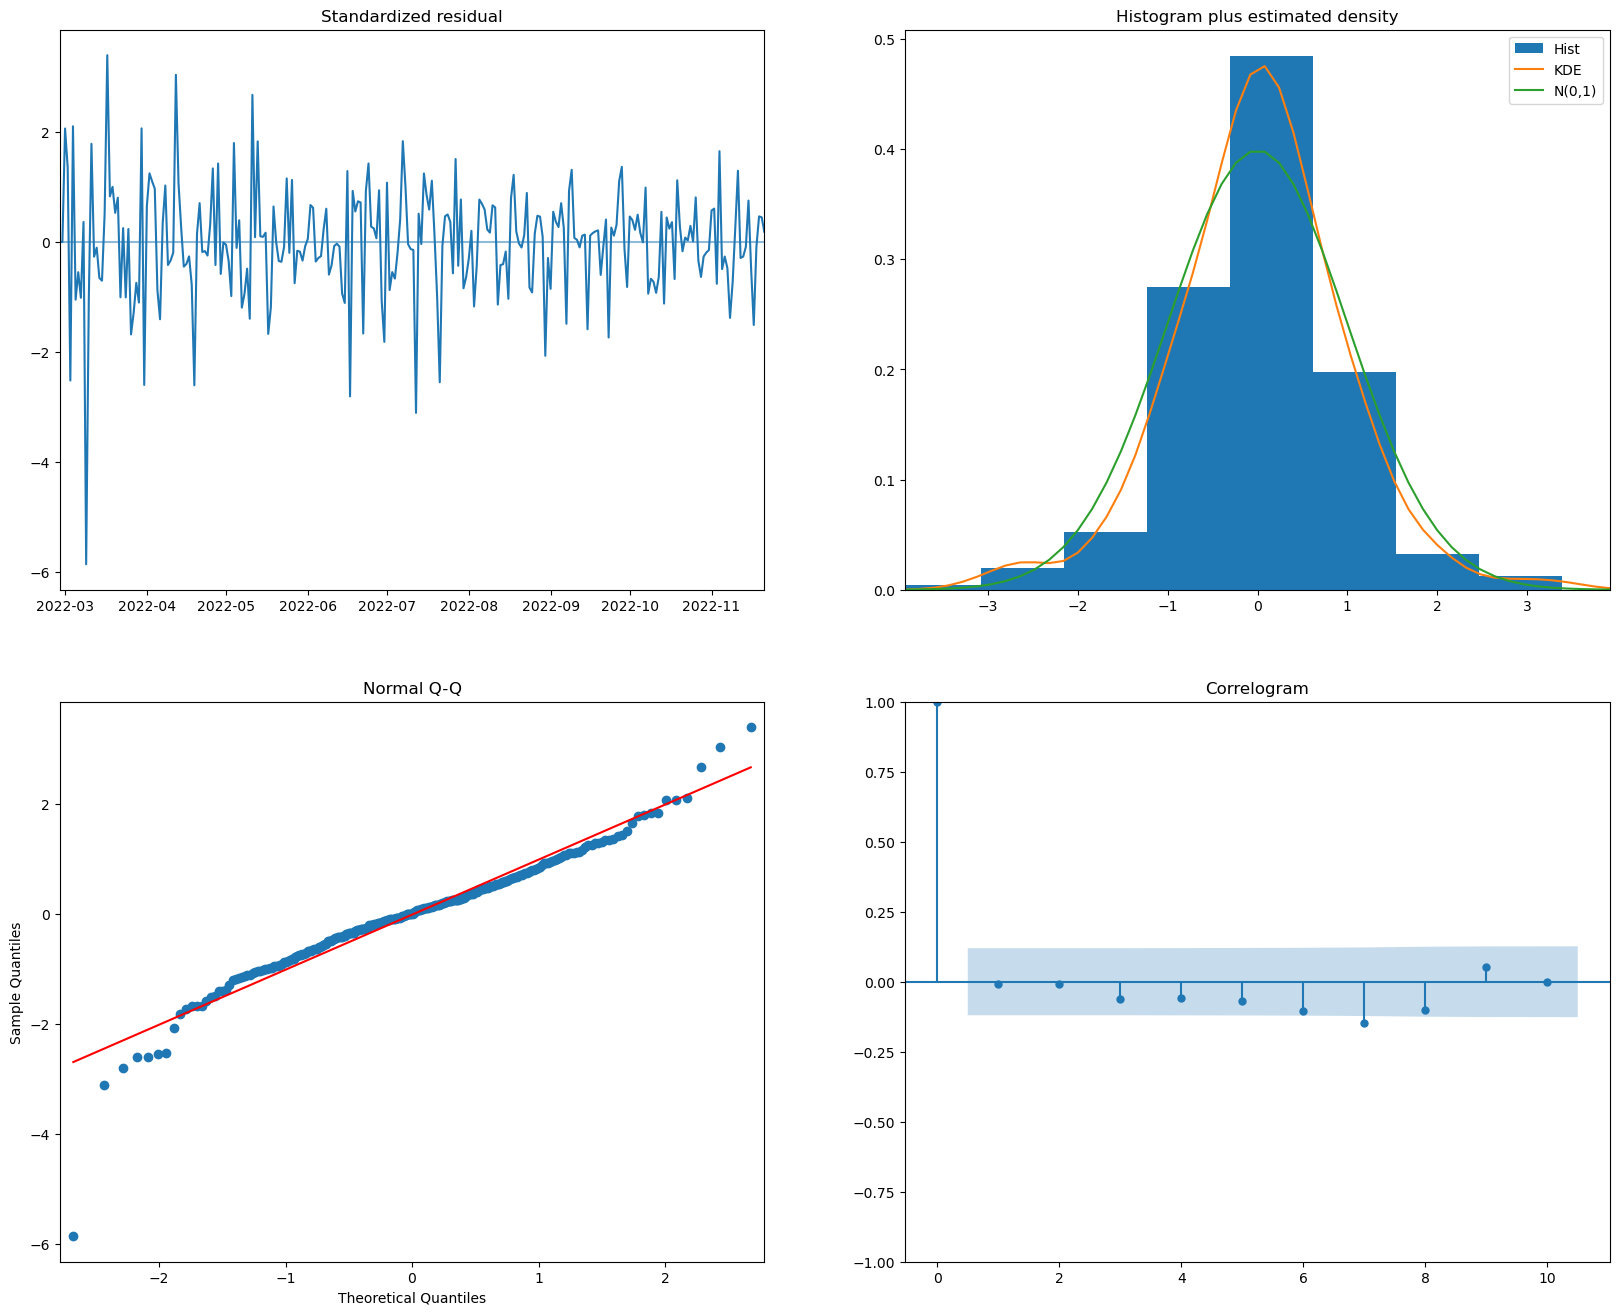

In [23]:
model_diff_2.plot_diagnostics(figsize=(20,16))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance EXCEPT between March and April.

Top Right: The density plot suggest the distribution roughly has a mean zero, but has data much more concentrated towards the mean compared to a normal distribution.

Bottom left: The dots fall roughly in line with the red line, so there's no strong skewness.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

**HONESTLY, NOT QUITE SURE IF THIS IS A GOOD MODEL**

# Predict the Results

In [24]:
price_full = price_full.sort_index()

In [29]:
length = len(price_full) - len(price_full[price_full.index > datetime(2022, 11, 1)])

In [32]:
train = price_full[:length]
test = price_full[length:]

train_diff = price_full_diff[:length]
test_diff = price_full_diff[length:]

train_diff_2 = price_full_diff_2[:length]
test_diff_2 = price_full_diff_2[length:]

model.fit(train)
model_diff.fit(train_diff)
model_diff_2.fit(train_diff_2)

forecast=model.predict(n_periods=20, return_conf_int=True)
forecast_diff=model_diff.predict(n_periods=19, return_conf_int=True)
forecast_diff_2=model_diff_2.predict(n_periods=18,return_conf_int=True)

forecast_df = forecast[0].to_frame()
forecast_df.index = test.index
forecast_df.rename(columns={0:'prediction'}, inplace=True)

forecast_df_1 = forecast_diff[0].to_frame()
forecast_df_1.index = test_diff.index
forecast_df_1.rename(columns={0:'prediction'}, inplace=True)

forecast_df_2 = forecast_diff_2[0].to_frame()
forecast_df_2.index = test_diff_2.index
forecast_df_2.rename(columns={0:'prediction'}, inplace=True)

### No Differencing

In [33]:
predictions = test.join(forecast_df)

nones = [None]*len(train)
s = pd.Series(nones, name="predictions")
s.to_frame()

train.join(s)

predit_df= pd.concat([train, predictions])

Text(0.5, 1.0, 'Prediction (Orange) vs. Reality (Blue)')

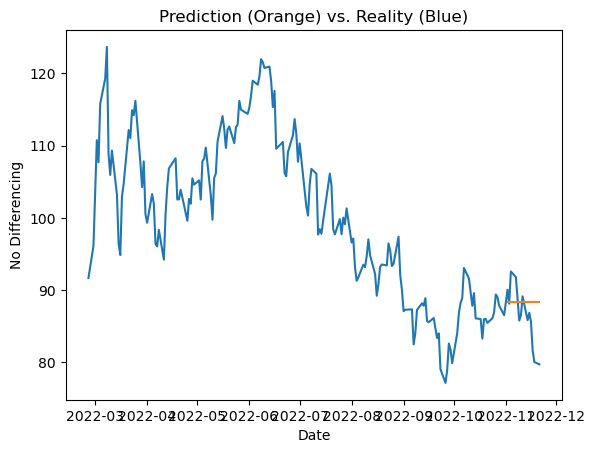

In [34]:
plt.plot(predit_df)
plt.xlabel("Date")
plt.ylabel("No Differencing")
plt.title("Prediction (Orange) vs. Reality (Blue)")

### 1st Order Differencing

In [35]:
predictions_diff = test_diff.join(forecast_df_1)

nones = [None]*len(train_diff)
s = pd.Series(nones, name="predictions")
s.to_frame()

train_diff.join(s)

predit_df_diff= pd.concat([train_diff, predictions_diff])

Text(0.5, 1.0, 'Prediction (Orange) vs. Reality (Blue)')

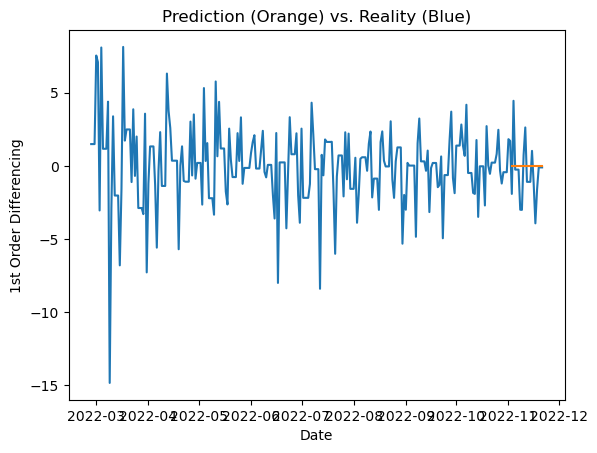

In [36]:
plt.plot(predit_df_diff)
plt.xlabel("Date")
plt.ylabel("1st Order Differencing")
plt.title("Prediction (Orange) vs. Reality (Blue)")

### 2nd Order Differencing

In [37]:
predictions = test_diff_2.join(forecast_df_2)

nones = [None]*len(train_diff_2)
s = pd.Series(nones, name="predictions")
s.to_frame()

train_diff_2.join(s)

predit_df_diff_2= pd.concat([train_diff_2, predictions])

Text(0.5, 1.0, 'Prediction (Orange) vs. Reality (Blue)')

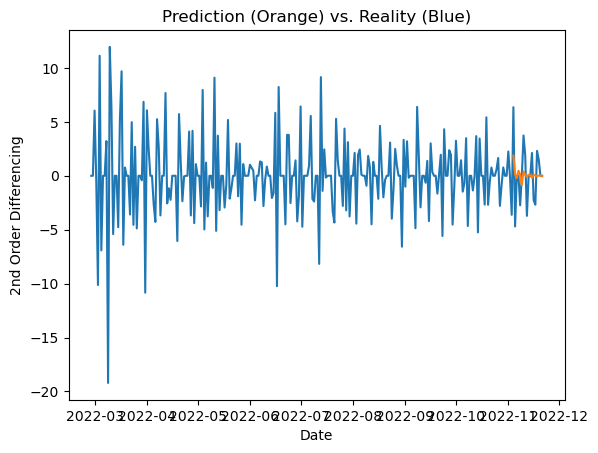

In [38]:
plt.plot(predit_df_diff_2)
plt.xlabel("Date")
plt.ylabel("2nd Order Differencing")
plt.title("Prediction (Orange) vs. Reality (Blue)")

As we can see, it's not a very good prediction...

# Accuracy Evaluation

In [39]:
def rse(predictions, Y):
    error = Y - predictions
    squaredError = np.square(error)
    sse = np.sum(squaredError)
    rse = np.sqrt(np.divide(sse,len(Y)-2))
    return rse
def mse(predictions, Y):
    mse = np.mean((predictions - Y)**2)
    return mse
def mae(predictions, Y):
    mae = np.mean(np.abs(predictions - Y))
    return mae

rse1 = rse(predit_df.dropna()['prediction'], predit_df.dropna()['price'])
rse2 = rse(predit_df_diff.dropna()['prediction'], predit_df_diff.dropna()['price'])
rse3 = rse(predit_df_diff_2.dropna()['prediction'], predit_df_diff_2.dropna()['price'])

mse1 = mse(predit_df.dropna()['prediction'], predit_df.dropna()['price'])
mse2 = mse(predit_df_diff.dropna()['prediction'], predit_df_diff.dropna()['price'])
mse3 = mse(predit_df_diff_2.dropna()['prediction'], predit_df_diff_2.dropna()['price'])

mae1 = mae(predit_df.dropna()['prediction'], predit_df.dropna()['price'])
mae2 = mae(predit_df_diff.dropna()['prediction'], predit_df_diff.dropna()['price'])
mae3 = mae(predit_df_diff_2.dropna()['prediction'], predit_df_diff_2.dropna()['price'])

print("RSE's")
print(rse1)
print(rse2)
print(rse3)
print("MSE's")
print(mse1)
print(mse2)
print(mse3)
print("MAE's")
print(mae1)
print(mae2)
print(mae3)

RSE's
4.838316907130741
2.0775655059161315
2.5731897513173334
MSE's
21.068379444444464
3.8619333333333365
5.885604885586276
MAE's
3.591500000000001
1.4705263157894743
1.8800742553077943


# Reference

* https://www.justintodata.com/arima-models-in-python-time-series-prediction/
* https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/
* https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python
* https://people.duke.edu/~rnau/411arim2.htm